In [140]:
import _pipeline
import random


In [390]:
import json

# Bidi override characters
LRO = chr(0x202D)  # Left-to-Right Override
RLO = chr(0x202E)  # Right-to-Left Override
LRI = chr(0x2066)  # Left-to-Right Isolate
RLI = chr(0x2067)  # Right-to-Left Isolate
PDI = chr(0x2069)  # Pop Directional Isolate
PDF = chr(0x202C)  # Pop Directional Formatting



class TagAttack:
    def __init__(self, perturbation_budget, tags= [0xE0001,*range(0xE0020, 0xE007F+1)]):
        self.perturbation_budget = perturbation_budget
        self.tags = tags

    def perturb(self, text):
        """
        Insert random Unicode tag characters into text, treating each
        Unicode codepoint as a single character.
        """
        # Convert string to list of codepoints
        codepoints = [ord(c) for c in text]

        for i in range(self.perturbation_budget):
            # Choose random position in codepoint list
            rand_index = random.randrange(len(codepoints) + 1)  # +1 to allow appending
            rand_tag = random.choice(self.tags)

            # Insert the tag codepoint at the chosen position
            codepoints.insert(rand_index, rand_tag)

        # Convert back to string
        return "".join(chr(cp) for cp in codepoints)


class VariationSelectorAttack:
    def __init__(self, perturbation_budget, variation_selectors = [*range(0xFE00, 0xFE0F + 1), *range(0xE0100, 0xE01EF + 1)]):
        self.perturbation_budget = perturbation_budget
        self.variation_selectors = variation_selectors

    def perturb(self, text):
        # Convert string to list of codepoints
        codepoints = [ord(c) for c in text]

        for _ in range(self.perturbation_budget):
            # Choose random position in codepoint list
            rand_index = random.randrange(len(codepoints) + 1)  # allow append
            rand_vs = random.choice(self.variation_selectors)

            # Insert the variation selector codepoint
            codepoints.insert(rand_index, rand_vs)

        # Convert back to string
        return "".join(chr(cp) for cp in codepoints)


class InvisibleCharAttack:
    def __init__(self, perturbation_budget, invisible_chars=[0x200B, 0x200C, 0x200D, 0x2060, 0xFEFF]):
        self.perturbation_budget = perturbation_budget
        self.invisible_chars = invisible_chars

    def perturb(self, text):
        # Convert string to list of codepoints
        codepoints = [ord(c) for c in text]

        for _ in range(self.perturbation_budget):
            # Choose random position in codepoint list
            rand_index = random.randrange(len(codepoints) + 1)  # allow append
            rand_invisible = random.choice(self.invisible_chars)

            # Insert the invisible character
            codepoints.insert(rand_index, rand_invisible)

        # Convert back to string
        return "".join(chr(cp) for cp in codepoints)


class HomoglyphAttack:
    def __init__(self, perturbation_budget, homoglyph_map_path='/home/carolkhor/YearII/Dissertation/imperceptible-perturbations/project/utils/homoglyphs/intentional.json'):
        self.perturbation_budget = perturbation_budget
        with open(homoglyph_map_path, 'r') as f:
            hex_map = json.load(f)
        # Convert hex strings to codepoints
        self.homoglyph_map = {int(k, 16): int(v, 16) for k, v in hex_map.items()}
        self.homoglyph_chars = list(self.homoglyph_map.keys())

    def perturb(self, text):
        # Convert string to list of codepoints
        codepoints = [ord(c) for c in text]
        
        # Replace random characters with homoglyphs
        indices = list(range(len(codepoints)))
        random.shuffle(indices)
        
        for i in indices[:min(self.perturbation_budget, len(indices))]:
            cp = codepoints[i]
            # If character has a homoglyph, replace it
            if cp in self.homoglyph_map:
                codepoints[i] = self.homoglyph_map[cp]

        # Convert back to string
        return "".join(chr(cp) for cp in codepoints)


class DeletionCharAttack:
    def __init__(self, perturbation_budget, deletion_char=0x8):
        self.perturbation_budget = perturbation_budget
        self.deletion_char = deletion_char  # Backspace character
        self.ascii_chars = list(range(32, 127))  # Printable ASCII characters

    def perturb(self, text):
        # Convert string to list of codepoints
        codepoints = [ord(c) for c in text]
        
        for _ in range(self.perturbation_budget):
            # Choose random position in codepoint list
            rand_index = random.randrange(len(codepoints) + 1)  # allow append
            # Insert random ASCII character followed by deletion character
            rand_ascii = random.choice(self.ascii_chars)
            codepoints.insert(rand_index, rand_ascii)
            codepoints.insert(rand_index + 1, self.deletion_char)

        # Convert back to string
        return "".join(chr(cp) for cp in codepoints)

import json
import random

# Bidi override characters
RLO = chr(0x202E)   # Right-to-Left Override
PDF = chr(0x202C)   # Pop Directional Formatting
RLI = chr(0x2067)   # Right-to-Left Isolate
PDI = chr(0x2069)   # Pop Directional Isolate
LRO = chr(0x202D)   # Left-to-Right Override
LRI = chr(0x2066)   # Left-to-Right Isolate
# ... (Other classes like Swap, TagAttack, etc., remain unchanged) ...

class BidiAttack:
    def __init__(self, perturbation_budget):
        self.perturbation_budget = perturbation_budget
    
    def _encode_swap_spoof(self, one, two):
        """
        Creates a string that contains the characters 'two' followed by 'one' 
        in the data, but is displayed as 'one' followed by 'two'.
        Sequence: RLO + two + one + PDF
        """
        # LRO, LRI, RLO, LRI, el.two, PDI, LRI, el.one, PDI, PDF, PDI, PDF
        
        # Display order is visually reversed by RLO
        return LRO + LRI+ RLO + LRI + two + PDI + LRI + one + PDI + PDF + PDI + PDF

    def perturb(self, text):
        """
        Swaps random *non-overlapping* adjacent character pairs in the 
        underlying data and uses Bidi controls to visually reverse the swap.
        """
        chars = list(text)
        n = len(chars)
        
        possible_start_indices = list(range(n - 1))
        random.shuffle(possible_start_indices)
        
        swaps_to_make = set()
        swaps_remaining = self.perturbation_budget
        
        # Select non-overlapping swap positions
        for i in possible_start_indices:
            if i not in swaps_to_make and i + 1 not in swaps_to_make:
                if swaps_remaining > 0:
                    swaps_to_make.add(i)
                    # Add the next index to the set to prevent it from starting a new swap
                    swaps_to_make.add(i + 1) 
                    swaps_remaining -= 1
                else:
                    break

        swaps_to_make = []
        available_positions = list(range(n - 1))
        random.shuffle(available_positions)
        
        processed_indices = set()
        
        for pos in available_positions:
            # A swap starts at 'pos' and involves 'pos' and 'pos + 1'
            if pos not in processed_indices and (pos + 1) not in processed_indices:
                if len(swaps_to_make) < self.perturbation_budget:
                    swaps_to_make.append(pos)
                    # Mark both characters in the pair as 'used'
                    processed_indices.add(pos)
                    processed_indices.add(pos + 1)
                else:
                    break
        
        
        # Build perturbed text
        perturbed_text = ""
        i = 0
        while i < n:
            if i in swaps_to_make and chars[i].isalpha() and chars[i + 1].isalpha():
                # This index starts a swap
                char_one = chars[i]
                char_two = chars[i + 1]
                
                # Data: two, one (visually displays as: one, two)
                spoofed_pair = self._encode_swap_spoof(char_one, char_two)
                perturbed_text += spoofed_pair
                
                # Advance counter by 2 since both characters were processed
                i += 2 
            else:
                # Add normal character
                perturbed_text += chars[i]
                i += 1
                
        return perturbed_text

In [408]:
txt = " ."
txt = "ab"
bidi_attack = BidiAttack(perturbation_budget=2)
invis_attack = InvisibleCharAttack(perturbation_budget=2)
perturbed = bidi_attack.perturb(txt)
perturbed = invis_attack.perturb(perturbed)
print(f"Perturbed: '{perturbed}'")
print(f"Length in codepoints: {len(perturbed)}")
print(f"Codepoints: {[hex(ord(c)) for c in perturbed]}")

p = _pipeline.Pipeline()
p.add_bidi_sanitizer()
p.add_invisible_sanitizer()
sanitised = p.sanitize(perturbed)
print(txt == sanitised)


print(f"Sanitised: {[hex(ord(c)) for c in sanitised]}")
print(f"Text: {[hex(ord(c)) for c in txt]}")

Perturbed: '‭⁦‮⁦﻿b⁩‌⁦a⁩‬⁩‬'
Length in codepoints: 14
Codepoints: ['0x202d', '0x2066', '0x202e', '0x2066', '0xfeff', '0x62', '0x2069', '0x200c', '0x2066', '0x61', '0x2069', '0x202c', '0x2069', '0x202c']
True
Sanitised: ['0x61', '0x62']
Text: ['0x61', '0x62']


In [143]:
delAttack = DeletionCharAttack(perturbation_budget=3)
txt = "abc"
del_text = delAttack.perturb(txt)
print(f"Perturbed: '{del_text}'")
print(f"Length in codepoints: {len(del_text)}")
print(f"Codepoints: {[hex(ord(c)) for c in del_text]}")

p = _pipeline.Pipeline()
p.add_deletion_sanitizer()
sanitised = p.sanitize(del_text)
print(f"Sanitised: {[hex(ord(c)) for c in sanitised]}")

Perturbed: 'abc'
Length in codepoints: 9
Codepoints: ['0x66', '0x8', '0x54', '0x8', '0x61', '0x79', '0x8', '0x62', '0x63']
Sanitised: ['0x61', '0x62', '0x63']


In [144]:
tagAttack = TagAttack(perturbation_budget=3)
txt = "abc"
tag_text = tagAttack.perturb(txt)
print(f"Perturbed: '{tag_text}'")
print(f"Length in codepoints: {len(tag_text)}")
print(f"Codepoints: {[hex(ord(c)) for c in tag_text]}")

p = _pipeline.Pipeline()
p.add_tag_sanitizer()
sanitised = p.sanitize(tag_text)
print(f"Sanitised: {[hex(ord(c)) for c in sanitised]}")

Perturbed: '󠀥󠁫abc󠀷'
Length in codepoints: 6
Codepoints: ['0xe0025', '0xe006b', '0x61', '0x62', '0x63', '0xe0037']
Sanitised: ['0x61', '0x62', '0x63']


In [145]:
variationSelectorAttack = VariationSelectorAttack(perturbation_budget=3)
perturbed = variationSelectorAttack.perturb("abc")
print(f"Perturbed: '{perturbed}'")
print(f"Length in codepoints: {len(perturbed)}")
print(f"Codepoints: {[hex(ord(c)) for c in perturbed]}")

p = _pipeline.Pipeline()
p.add_variation_selector_sanitizer()
sanitised = p.sanitize(perturbed)
print(f"Sanitised: {[hex(ord(c)) for c in sanitised]}")

Perturbed: '󠅩󠆂︌abc'
Length in codepoints: 6
Codepoints: ['0xe0169', '0xe0182', '0xfe0c', '0x61', '0x62', '0x63']
Sanitised: ['0x61', '0x62', '0x63']


In [ ]:
!pip install datasets
!pip install matplotlib

In [415]:
import csv
import time
import pandas as pd
from datasets import load_dataset

# Configuration
perturbation_budgets = range(0, 1000,100)
num_samples = 50
output_file = "all_attacks_results.csv"

print(f"Perturbation budgets: {list(perturbation_budgets)}")
print(f"Samples per budget: {num_samples}\n")

# Load dataset
sst2 = load_dataset("glue", "sst2", split="validation")
texts = sst2['sentence'][:num_samples]


results = []

for budget in perturbation_budgets:
    print(f"Budget {budget}...", end=" ")
    
    # All six attacks
    tag_attack = TagAttack(perturbation_budget=budget)
    vs_attack = VariationSelectorAttack(perturbation_budget=budget)
    invisible_attack = InvisibleCharAttack(perturbation_budget=budget)
    homoglyph_attack = HomoglyphAttack(perturbation_budget=budget)
    deletion_attack = DeletionCharAttack(perturbation_budget=budget)
    bidi_attack = BidiAttack(perturbation_budget=budget)
    
    # Apply all attacks sequentially to each text
    all_attacks_perturbed = []
    for text in texts:
        perturbed = tag_attack.perturb(text)
        perturbed = vs_attack.perturb(perturbed)
        perturbed = invisible_attack.perturb(perturbed)
        perturbed = homoglyph_attack.perturb(perturbed)
        perturbed = deletion_attack.perturb(perturbed)
        perturbed = bidi_attack.perturb(perturbed)
        all_attacks_perturbed.append(perturbed)
    
    # Run all sanitizers in single pipeline
    p_all = _pipeline.Pipeline()
    p_all.add_bidi_sanitizer()
    p_all.add_tag_sanitizer()
    p_all.add_variation_selector_sanitizer()
    p_all.add_invisible_sanitizer()
    p_all.add_homoglyph_sanitizer()
    p_all.add_deletion_sanitizer()
    
    
    start = time.time()
    sanitized_all = [p_all.sanitize(text) for text in all_attacks_perturbed]
    sanitize_time_all = (time.time() - start) / num_samples * 1000
    
    recovered_all = sum(1 for i in range(num_samples) if sanitized_all[i] == texts[i])
    recovery_rate_all = recovered_all / num_samples * 100
    
    results.append({
        'budget': budget,
        'sanitize_ms': f"{sanitize_time_all:.2f}",
        'recovered': f"{recovered_all}/{num_samples}",
        'recovery_rate': f"{recovery_rate_all:.1f}%"
    })

# Save to CSV
csv_columns = ['budget', 'sanitize_ms', 'recovered', 'recovery_rate']
with open(output_file, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=csv_columns)
    writer.writeheader()
    writer.writerows(results)

print("done")
print(f"\nResults saved to {output_file}\n")


Perturbation budgets: [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
Samples per budget: 50



Budget 0... Budget 100... Budget 200... Budget 300... Budget 400... Budget 500... Budget 600... Budget 700... Budget 800... Budget 900... done

Results saved to all_attacks_results.csv



In [416]:
not_recovered = [(texts[i], sanitized_all[i]) for i in range(num_samples) if sanitized_all[i] != texts[i]]
not_recovered

[]

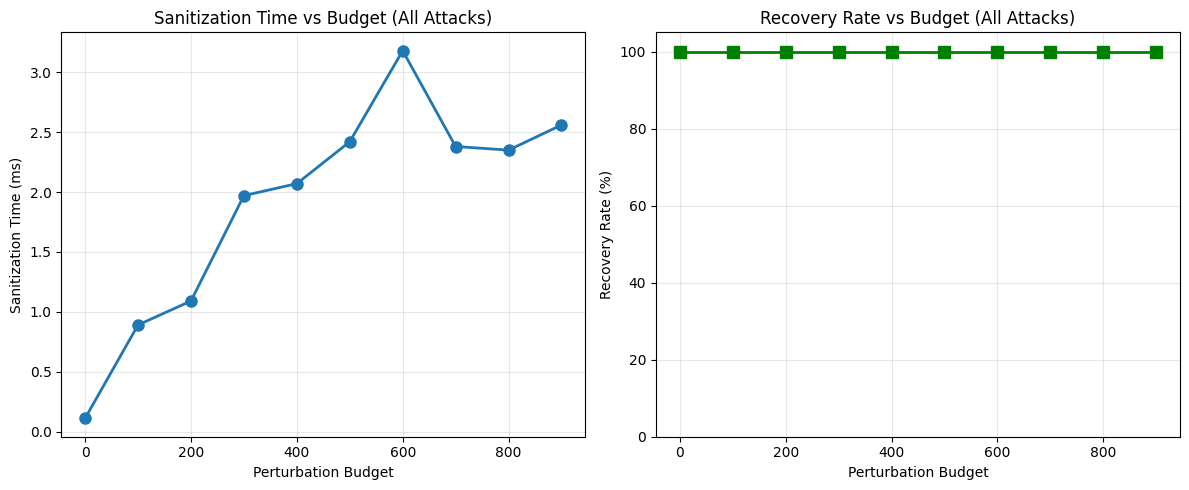


Results Summary:
 budget sanitize_ms recovered recovery_rate  sanitize_ms_num  recovery_rate_num
      0        0.11     50/50        100.0%             0.11              100.0
    100        0.89     50/50        100.0%             0.89              100.0
    200        1.09     50/50        100.0%             1.09              100.0
    300        1.97     50/50        100.0%             1.97              100.0
    400        2.07     50/50        100.0%             2.07              100.0
    500        2.42     50/50        100.0%             2.42              100.0
    600        3.18     50/50        100.0%             3.18              100.0
    700        2.38     50/50        100.0%             2.38              100.0
    800        2.35     50/50        100.0%             2.35              100.0
    900        2.56     50/50        100.0%             2.56              100.0


In [418]:
import matplotlib.pyplot as plt

# Display results
summary_df = pd.DataFrame(results)

# Convert numeric columns for plotting
summary_df['sanitize_ms_num'] = summary_df['sanitize_ms'].astype(float)
summary_df['recovery_rate_num'] = summary_df['recovery_rate'].str.rstrip('%').astype(float)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Sanitization time vs budget
axes[0].plot(summary_df['budget'], summary_df['sanitize_ms_num'], marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Perturbation Budget')
axes[0].set_ylabel('Sanitization Time (ms)')
axes[0].set_title('Sanitization Time vs Budget (All Attacks)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Recovery rate vs budget
axes[1].plot(summary_df['budget'], summary_df['recovery_rate_num'], marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Perturbation Budget')
axes[1].set_ylabel('Recovery Rate (%)')
axes[1].set_title('Recovery Rate vs Budget (All Attacks)')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 105])

plt.tight_layout()
plt.show()

print("\nResults Summary:")
print(summary_df.to_string(index=False))


In [149]:
print("abc\b\b\b")

ab
